<a href="https://colab.research.google.com/github/Vanessa-Ongodi/Certification-Projects/blob/main/Stage_C_Data_Storytelling_Project_by_Vanessa_Onyema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comeback Coins 

A HDSC Winter 2022 Data storytelling project on first generation (bitcoin) and second generation (ethereum) cryptocurrency.

In [1]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import bs4 as bs
from bs4 import BeautifulSoup
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot
import plotly.io as pio

<h2 id="DSCW">Downloading And Scraping The Contents Of A Web Page</h2> 


We Download the contents of the web page:


In [2]:
url = "http://www.cryptowat.ch"

We use <code>get</code> to download the contents of the webpage in text format and store in a variable called <code>data</code>:


In [3]:
data  = requests.get(url).text 

We create a <code>BeautifulSoup</code> object using the <code>BeautifulSoup</code> constructor


In [4]:
soup = BeautifulSoup(data,"html.parser")  # create a soup object using the variable 'data'

Scrape all links


In [5]:
for link in soup.find_all('a',href=True):  # in html anchor/link is represented by the tag <a>

    print(link.get('href'))


/
account/login
/account/create
/charts
/assets
/exchanges
/desktop
/mobile
/pricing
/markets
/correlations
/products/cryptocurrency-market-data-api
/converter
/account/create
/account/create


This helps us identify the contents of the webpage and how we can scrape the data. The data we need is from the cryptocurrency markets. We see there is an information on crypto market here so I will inspect the contents.

In [6]:
url="https://api.cryptowat.ch/markets"

In [7]:
# get the contents of the webpage in text format and store in a variable called data
data  = requests.get(url).text

In [8]:
soup = BeautifulSoup(data,"html.parser")

In [9]:
def formatter(string):
    formatted = bytes(string, 'ascii').decode('unicode-escape')
    # for Python 2
    # formatted = string.decode('unicode-escape')
    return formatted

In [10]:
#print(soup.prettify(formatter = formatter))
#This prints the web page elements from which I selected the data I need. Because these slows down the notebook, I won't run the output. 

There are a lot of exchange market like bitfitnex, kraken, ftx-us, binance, etc. For this analysis, I will go with binance.

In [11]:
#scrape the data by creating a function
def get_crypto_price(symbol, exchange='binance', after='2018-09-01'):
    url = 'https://api.cryptowat.ch/markets/{exchange}/{symbol}usd/ohlc'.format(
        symbol=symbol, exchange=exchange)
    resp = requests.get(url, params={
        'periods': '7200',
        'after': str(int(pd.Timestamp(after).timestamp()))
    })
#     resp.raise_for_status()
    data = resp.json()
    df = pd.DataFrame(data['result']['7200'], columns=[
        'CloseTime', 'OpenPrice', 'HighPrice', 'LowPrice', 'ClosePrice', 'Volume', 'NA'
    ])
    df['CloseTime'] = pd.to_datetime(df['CloseTime'], unit='s')
    df.set_index('CloseTime', inplace=True)
    return df

In [12]:
#pull data from crypto for btc and eth
btc = get_crypto_price('btc', 'bitstamp')
eth = get_crypto_price('eth', 'bitstamp')

In [13]:
#pull others for comparison
ada = get_crypto_price('ada', 'bitstamp')
xrp = get_crypto_price('xrp', 'bitstamp')
usdt = get_crypto_price('usdt', 'bitstamp')
matic = get_crypto_price('matic', 'bitstamp')
usdc = get_crypto_price('usdc', 'bitstamp')
shib = get_crypto_price('shib', 'bitstamp')
ftm = get_crypto_price('ftm', 'bitstamp')
uma = get_crypto_price('uma', 'bitstamp')

## Descriptive Statistics

In [14]:
btc.describe()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume,NA
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6.000000e+03
mean,42430.631015,42790.082087,42031.035243,42434.985205,427.542577,1.613663e+07
std,13226.449452,13301.302787,13138.891116,13220.918704,530.731436,1.887520e+07
min,12702.200000,12810.500000,12680.350000,12702.200000,0.677546,2.645365e+04
25%,34710.270000,35100.202500,34270.007500,34710.460000,133.922476,5.624408e+06
50%,43540.255000,43892.495000,43155.455000,43538.635000,265.951761,1.055232e+07
75%,51905.822500,52388.495000,51503.307500,51904.875000,517.363658,1.978923e+07
max,68635.050000,69000.000000,68357.790000,68627.010000,8477.638827,3.175776e+08


In [15]:
eth.describe()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume,NA
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6.000000e+03
mean,2475.094640,2500.205093,2446.814950,2475.308313,4268.467781,8.295064e+06
std,1193.215445,1201.940739,1183.315826,1192.898665,5692.980943,1.044996e+07
min,374.180000,376.260000,370.430000,374.100000,4.488160,1.183418e+04
25%,1684.117500,1700.562500,1664.860000,1684.957500,1102.722437,2.490819e+06
50%,2502.655000,2536.300000,2467.025000,2501.590000,2386.795645,4.931978e+06
75%,3365.000000,3405.682500,3326.895000,3364.760000,5004.078172,1.010107e+07
max,4849.970000,4868.790000,4826.000000,4849.060000,69943.152785,1.279678e+08


The dataset is between 1-6000 rows and 6 columns.

## Data Preprocessing and Cleaning

In [16]:
#export to csv to make the index a column
btc.to_csv('btc.csv', index=True)
eth.to_csv('eth.csv', index=True)
ada.to_csv('ada.csv', index=True)
xrp.to_csv('xrp.csv', index=True)
usdt.to_csv('usdt.csv', index=True)
matic.to_csv('matic.csv', index=True)
usdc.to_csv('usdc.csv', index=True)
shib.to_csv('shib.csv', index=True)
ftm.to_csv('ftm.csv', index=True)
uma.to_csv('uma.csv', index=True)

In [17]:
#import
df_btc = pd.read_csv('btc.csv')
df_eth = pd.read_csv('eth.csv')
df_ada = pd.read_csv('ada.csv')
df_xrp = pd.read_csv('xrp.csv')
df_usdt = pd.read_csv('usdt.csv')
df_matic = pd.read_csv('matic.csv')
df_usdc = pd.read_csv('usdc.csv')
df_shib = pd.read_csv('shib.csv')
df_ftm = pd.read_csv('ftm.csv')
df_uma = pd.read_csv('uma.csv')

In [18]:
#assign new column
df_btc['Symbol'] = "BTC"
df_eth['Symbol'] = "ETH"
df_ada['Symbol'] = "ADA"
df_xrp['Symbol'] = "XRP"
df_usdt['Symbol'] = "USDT"
df_matic['Symbol'] = "MATIC"
df_usdc['Symbol'] = "USDC"
df_shib['Symbol'] = "SHIB"
df_ftm['Symbol'] = "FTM"
df_uma['Symbol'] = "UMA"

In [19]:
#join the dataframe for data comparison later
coins = pd.concat([df_btc, df_eth, df_ada, df_xrp, df_usdt, df_matic, df_usdc, df_shib, df_ftm, df_uma], axis=0)
coins.head()

,CloseTime,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume,NA,Symbol
0,2020-10-21 18:00:00,12758.29,12918.29,12728.37,12784.18,1476.877589,1.895998e+07,BTC
1,2020-10-21 20:00:00,12785.87,12815.00,12680.35,12702.20,1146.518601,1.462697e+07,BTC
2,2020-10-21 22:00:00,12702.20,13010.00,12700.00,12926.83,1524.816948,1.963351e+07,BTC
3,2020-10-22 00:00:00,12943.43,13235.00,12749.07,12802.67,3310.833279,4.299027e+07,BTC
4,2020-10-22 02:00:00,12802.63,12949.37,12794.95,12862.97,308.762844,3.981358e+06,BTC


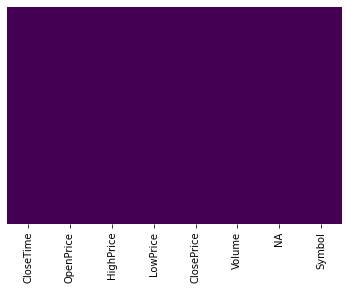

In [20]:
#check null values
sns.heatmap(coins.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

Here we see that there are no missing values in the data set

In [21]:
#convert the CloseTime column to datetime format
coins['CloseTime']= pd.to_datetime(coins['CloseTime'])
 

In [22]:
#extract year and month into separate column
coins['Year'] = pd.to_datetime(coins['CloseTime']).dt.year
coins['Month'] = pd.to_datetime(coins['CloseTime']).dt.month

In [23]:
coins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34538 entries, 0 to 3345
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CloseTime   34538 non-null  datetime64[ns]
 1   OpenPrice   34538 non-null  float64       
 2   HighPrice   34538 non-null  float64       
 3   LowPrice    34538 non-null  float64       
 4   ClosePrice  34538 non-null  float64       
 5   Volume      34538 non-null  float64       
 6   NA          34538 non-null  float64       
 7   Symbol      34538 non-null  object        
 8   Year        34538 non-null  int64         
 9   Month       34538 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 2.9+ MB


In [24]:
coins.head()

,CloseTime,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume,NA,Symbol,Year,Month
0,2020-10-21 18:00:00,12758.29,12918.29,12728.37,12784.18,1476.877589,1.895998e+07,BTC,2020,10
1,2020-10-21 20:00:00,12785.87,12815.00,12680.35,12702.20,1146.518601,1.462697e+07,BTC,2020,10
2,2020-10-21 22:00:00,12702.20,13010.00,12700.00,12926.83,1524.816948,1.963351e+07,BTC,2020,10
3,2020-10-22 00:00:00,12943.43,13235.00,12749.07,12802.67,3310.833279,4.299027e+07,BTC,2020,10
4,2020-10-22 02:00:00,12802.63,12949.37,12794.95,12862.97,308.762844,3.981358e+06,BTC,2020,10


## EDA

In [25]:
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

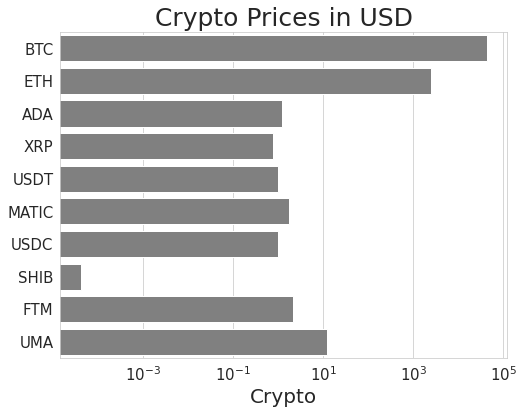

In [26]:
#use a barchart to view the coin performance
#create a bar chart using Seaborn
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(x='ClosePrice', y='Symbol', data=coins, ci=None, color='grey',orient='h')
ax.set_title("Crypto Prices in USD", fontsize=25)
ax.set(xscale="log")#set scale to view others
ax.set_xlabel ("Crypto", fontsize=20)
ax.set_ylabel (None, fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.savefig("cryptoprice.svg")


### From this point, the graphs were plotted with plotly and doesn't display on github. The EDA has been used in the storytelling report. To view the EDA, open the file on collab with the icon indicated at the top of the notebook.


In [27]:
#check mean performance of all
df=coins.groupby('Symbol').agg({'ClosePrice':np.mean,'OpenPrice':np.mean,'HighPrice':np.mean,'LowPrice':np.mean}).reset_index()
fig = px.line(df, x='Symbol', y=['ClosePrice','HighPrice','LowPrice','OpenPrice'])
fig.update_layout(autosize=False,
    width=400,
    height=400,template='plotly_dark',
    yaxis_title='Price',
    title='Mean OHLC Prices of crypto currencies',
    hovermode="x",
    title_x=0.5
)
fig.update_yaxes( # the y-axis is in dollars
    tickprefix="$", showgrid=True
)

# Analyzing bitcoin prices for 2020

In [28]:
df_2020 = coins[coins.Year == 2020]
df_2020_btc = df_2020[df_2020.Symbol == 'BTC']
df_2020_btc.head()

,CloseTime,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume,NA,Symbol,Year,Month
0,2020-10-21 18:00:00,12758.29,12918.29,12728.37,12784.18,1476.877589,1.895998e+07,BTC,2020,10
1,2020-10-21 20:00:00,12785.87,12815.00,12680.35,12702.20,1146.518601,1.462697e+07,BTC,2020,10
2,2020-10-21 22:00:00,12702.20,13010.00,12700.00,12926.83,1524.816948,1.963351e+07,BTC,2020,10
3,2020-10-22 00:00:00,12943.43,13235.00,12749.07,12802.67,3310.833279,4.299027e+07,BTC,2020,10
4,2020-10-22 02:00:00,12802.63,12949.37,12794.95,12862.97,308.762844,3.981358e+06,BTC,2020,10


In [29]:
#check growth for 2020
fig = go.Figure(data=go.Ohlc(x=df_2020_btc['CloseTime'],
                    open=df_2020_btc['OpenPrice'],
                    high=df_2020_btc['HighPrice'],
                    low=df_2020_btc['LowPrice'],
                    close=df_2020_btc['ClosePrice']))

fig.update_layout(autosize=False,
    width=400,
    height=400,template='plotly_dark',
        title='Bitcoin performance in 2020',
        xaxis_title="Date",
        yaxis_title='Price',title_x=0.5,
        )
fig.update_yaxes( # the y-axis is in dollars
        tickprefix="$", showgrid=False
    )

fig.update_xaxes(
         showgrid=True
    )

Here we see an increase from less than 15,000 USD to about 30,000 USD from October to December 2020.

In [30]:
#mean price
round(df_2020_btc['ClosePrice'].mean())

18343

In [31]:
#median price
round(df_2020_btc['ClosePrice'].median())

18251

In [32]:
#lowest price
round(df_2020_btc['ClosePrice'].min())

12702

In [33]:
#highest price
round(df_2020_btc['ClosePrice'].max())

29178

In [34]:
#extract for october to calculate the growth rate from october to december
df_2020_btc_oct = df_2020_btc[df_2020_btc.Month == 10]

In [35]:
round(((df_2020_btc['ClosePrice'].median()-df_2020_btc_oct['ClosePrice'].median())/df_2020_btc_oct['ClosePrice'].median())*100,2)

39.08

From October 2020 to December 2020, Bitcoin had a mean price of USD 18,065, median price of USD 18,110, low price of USD 11,430, highest price of USD 29,178 and a growth rate of 38.91%. 

# Analysing Bitcoin Prices for 2021

In [84]:
df_2021 = coins[coins.Year == 2021]
df_2021_btc = df_2021[df_2021.Symbol == 'BTC']
df_2021_btc.head()

,CloseTime,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume,NA,Symbol,Year,Month
855,2021-01-01 00:00:00,28987.60,29191.60,28843.74,28992.79,721.075916,2.094796e+07,BTC,2021,1
856,2021-01-01 02:00:00,28999.63,29543.93,28774.64,29479.12,1046.562427,3.057629e+07,BTC,2021,1
857,2021-01-01 04:00:00,29484.39,29535.95,29189.34,29345.63,574.389204,1.685687e+07,BTC,2021,1
858,2021-01-01 06:00:00,29351.85,29458.27,29121.80,29242.10,618.999929,1.812801e+07,BTC,2021,1
859,2021-01-01 08:00:00,29242.10,29317.56,28896.66,29173.17,693.177517,2.021690e+07,BTC,2021,1


In [85]:
#check growth for 2021
fig = go.Figure(data=go.Ohlc(x=df_2021_btc['CloseTime'],
                    open=df_2021_btc['OpenPrice'],
                    high=df_2021_btc['HighPrice'],
                    low=df_2021_btc['LowPrice'],
                    close=df_2021_btc['ClosePrice']))

fig.update_layout(autosize=False,
    width=400,
    height=400,template='plotly_dark',
        title='Bitcoin performance in 2021',
        xaxis_title="Date",
        yaxis_title='Price',title_x=0.5,
        )
fig.update_yaxes( # the y-axis is in dollars
        tickprefix="$", showgrid=False
    )

fig.update_xaxes(
         showgrid=True
    )


Here bitcoin price fluctuates between 30,000 USD to almost 70,000 USD. From January 2021 to April 2021, there was a steady climb to about 65,000 USD. From May 2021 to July 2021, there was a drop to 30,000 USD. From August 2021 to September 2021, it increased to 50,000 USD and increased to almost 70,000 USD from October to November 2021. It dropped down to 48,000 USD and ranges between 48,000 USD - 40,000 USD in December 2021.

In [86]:
#mean price
round(df_2021_btc['ClosePrice'].mean())

47387

In [87]:
#median price
round(df_2021_btc['ClosePrice'].median())

47943

In [88]:
#lowest price
round(df_2021_btc['ClosePrice'].min())

28993

In [89]:
#highest price
round(df_2021_btc['ClosePrice'].max())

68627

In [90]:
#extract for january to calculate the growth rate from january to december
df_2021_btc_jan = df_2021_btc[df_2021_btc.Month == 1]

In [91]:
round(((df_2021_btc['ClosePrice'].median()-df_2021_btc_jan['ClosePrice'].median())/df_2021_btc_jan['ClosePrice'].median())*100,2)

40.03

From January 2021 to December 2021, Bitcoin had a mean price of 47,387 USD, median price of 47,943 USD, low price of 28,993 USD, highest price of 68,627 USD and a growth rate of 40.03%. 

# Analyzing bitcoin prices for 2022

In [44]:
df_2022 = coins[coins.Year == 2022]
df_2022_btc = df_2022[df_2022.Symbol == 'BTC']
df_2022_btc.head()

,CloseTime,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume,NA,Symbol,Year,Month
5235,2022-01-01 00:00:00,46342.34,46560.81,46140.00,46214.37,93.470255,4.334748e+06,BTC,2022,1
5236,2022-01-01 02:00:00,46230.00,46921.30,46199.90,46773.08,83.770212,3.906125e+06,BTC,2022,1
5237,2022-01-01 04:00:00,46768.85,46928.90,46719.22,46814.16,55.389505,2.593773e+06,BTC,2022,1
5238,2022-01-01 06:00:00,46814.16,47548.93,46562.27,47214.92,155.973089,7.321566e+06,BTC,2022,1
5239,2022-01-01 08:00:00,47224.84,47327.29,46901.24,47236.65,32.892448,1.548375e+06,BTC,2022,1


In [45]:
#check growth for 2021
fig = go.Figure(data=go.Ohlc(x=df_2022_btc['CloseTime'],
                    open=df_2022_btc['OpenPrice'],
                    high=df_2022_btc['HighPrice'],
                    low=df_2022_btc['LowPrice'],
                    close=df_2022_btc['ClosePrice']))

fig.update_layout(autosize=False,
    width=400,
    height=400,template='plotly_dark',
        title='Bitcoin performance in 2022',
        xaxis_title="Date",
        yaxis_title='Price',title_x=0.5,
        )
fig.update_yaxes( # the y-axis is in dollars
        tickprefix="$", showgrid=False
    )

fig.update_xaxes(
         showgrid=True
    )


Here bitcoin price fluctuates between 45,000 USD to 35,000 USD from January 2022 to March 2022. There is either a steady decrease or a steady increase.

In [46]:
#mean price
round(df_2022_btc['ClosePrice'].mean())

41006

In [47]:
#median price
round(df_2022_btc['ClosePrice'].median())

41723

In [48]:
#lowest price
round(df_2022_btc['ClosePrice'].min())

33321

In [49]:
#highest price
round(df_2022_btc['ClosePrice'].max())

47777

In [50]:
#extract for january to calculate the growth rate from january to december
df_2022_btc_jan = df_2022_btc[df_2022_btc.Month == 1]

In [51]:
round(((df_2022_btc['ClosePrice'].median()-df_2022_btc_jan['ClosePrice'].median())/df_2022_btc_jan['ClosePrice'].median())*100,2)

-0.49

From January 2022 to present, Bitcoin has a mean price of 40,973 USD, median price of 41,729 USD, low price of 33,321 USD, highest price of 47,777 USD and a growth rate of -0.47%. 

# Analyzing bitcoin prices from 2020 - present

In [52]:
df_all_btc = coins[coins.Symbol == 'BTC']
df_all_btc.head()

,CloseTime,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume,NA,Symbol,Year,Month
0,2020-10-21 18:00:00,12758.29,12918.29,12728.37,12784.18,1476.877589,1.895998e+07,BTC,2020,10
1,2020-10-21 20:00:00,12785.87,12815.00,12680.35,12702.20,1146.518601,1.462697e+07,BTC,2020,10
2,2020-10-21 22:00:00,12702.20,13010.00,12700.00,12926.83,1524.816948,1.963351e+07,BTC,2020,10
3,2020-10-22 00:00:00,12943.43,13235.00,12749.07,12802.67,3310.833279,4.299027e+07,BTC,2020,10
4,2020-10-22 02:00:00,12802.63,12949.37,12794.95,12862.97,308.762844,3.981358e+06,BTC,2020,10


In [53]:
#check growth
fig = go.Figure(data=go.Ohlc(x=df_all_btc['CloseTime'],
                    open=df_all_btc['OpenPrice'],
                    high=df_all_btc['HighPrice'],
                    low=df_all_btc['LowPrice'],
                    close=df_all_btc['ClosePrice']))

fig.update_layout(autosize=False,
    width=400,
    height=400,template='plotly_dark',
        title='Bitcoin performance from 2020 - present',
        xaxis_title="Date",
        yaxis_title='Price',title_x=0.5,
        )
fig.update_yaxes( # the y-axis is in dollars
        tickprefix="$", showgrid=False
    )

fig.update_xaxes(
         showgrid=True
    )

From October 2020 to present, Bitcoin prices ranged from 10,000 USD to up to 70,000 USD with a steady increase or steady decrease.

In [54]:
#mean price
round(df_all_btc['ClosePrice'].mean())

42435

In [55]:
#median price
round(df_all_btc['ClosePrice'].median())

43539

In [56]:
#lowest price
round(df_all_btc['ClosePrice'].min())

12702

In [57]:
#highest price
round(df_all_btc['ClosePrice'].max())

68627

In [58]:
#use extracted data for october to calculate the growth rate from October 2020 to present
df_2020_btc = df_all_btc[df_all_btc.Year == 2020]

In [59]:
#use extracted data for october to calculate the growth rate from October 2020 to present
round(((df_all_btc['ClosePrice'].median()-df_2020_btc_oct['ClosePrice'].median())/df_2020_btc_oct['ClosePrice'].median())*100,2)

231.78

From October 2020 to present, Bitcoin has a mean price of 42,246 USD, median price of 43,514 USD, low price of 11,430 USD, highest price of 68,627 USD and a growth rate of 233.76%. 

# Analyzing ethereum prices for 2020

In [60]:
df_2020 = coins[coins.Year == 2020]
df_2020_eth = df_2020[df_2020.Symbol == 'ETH']
df_2020_eth.head()

,CloseTime,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume,NA,Symbol,Year,Month
0,2020-10-21 16:00:00,385.36,392.76,384.09,392.66,14082.805849,5.462723e+06,ETH,2020,10
1,2020-10-21 18:00:00,392.79,400.00,392.57,395.55,17972.866971,7.144007e+06,ETH,2020,10
2,2020-10-21 20:00:00,395.62,396.49,391.52,391.52,7928.965550,3.122114e+06,ETH,2020,10
3,2020-10-21 22:00:00,391.90,397.30,391.60,396.28,4705.146643,1.853941e+06,ETH,2020,10
4,2020-10-22 00:00:00,396.27,402.46,388.76,391.59,5113.876927,2.025348e+06,ETH,2020,10


In [61]:
#check growth for 2020
fig = go.Figure(data=go.Ohlc(x=df_2020_eth['CloseTime'],
                    open=df_2020_eth['OpenPrice'],
                    high=df_2020_eth['HighPrice'],
                    low=df_2020_eth['LowPrice'],
                    close=df_2020_eth['ClosePrice']))

fig.update_layout(autosize=False,
    width=400,
    height=400,template='plotly_dark',
        title='Ethereum performance in 2020',
        xaxis_title="Date",
        yaxis_title='Price',title_x=0.5,
        )
fig.update_yaxes( # the y-axis is in dollars
        tickprefix="$", showgrid=False
    )

fig.update_xaxes(
         showgrid=True
    )


Here we see an increase from less than 400 USD to about 700 USD from October to December 2020.

In [62]:
#mean price
round(df_2020_eth['ClosePrice'].mean())

529

In [63]:
#median price
round(df_2020_eth['ClosePrice'].median())

546

In [64]:
#lowest price
round(df_2020_eth['ClosePrice'].min())

374

In [65]:
#highest price
round(df_2020_eth['ClosePrice'].max())

753

In [66]:
#extract for october to calculate the growth rate from october to december
df_2020_eth_oct = df_2020_eth[df_2020_eth.Month == 10]

In [67]:
round(((df_2020_eth['ClosePrice'].median()-df_2020_eth_oct['ClosePrice'].median())/df_2020_eth_oct['ClosePrice'].median())*100,2)

37.57

From October 2020 to December 2020, Ethereum had a mean price of USD 523, median price of USD 538, low price of USD 368, highest price of USD 753 and a growth rate of 37.25%. 

# Analysing Ethereum Prices for 2021

In [68]:
df_2021 = coins[coins.Year == 2021]
df_2021_eth = df_2021[df_2021.Symbol == 'ETH']
df_2021_eth.head()

,CloseTime,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume,NA,Symbol,Year,Month
856,2021-01-01 00:00:00,739.34,743.34,733.57,737.24,4655.843587,3.444707e+06,ETH,2021,1
857,2021-01-01 02:00:00,737.50,750.34,731.00,749.99,3445.525872,2.548579e+06,ETH,2021,1
858,2021-01-01 04:00:00,749.93,750.06,743.81,746.42,3722.576636,2.779335e+06,ETH,2021,1
859,2021-01-01 06:00:00,746.36,748.53,741.10,741.92,3590.832176,2.670283e+06,ETH,2021,1
860,2021-01-01 08:00:00,742.96,744.09,735.55,738.18,6876.177298,5.084683e+06,ETH,2021,1


In [69]:
#check growth for 2021
fig = go.Figure(data=go.Ohlc(x=df_2021_eth['CloseTime'],
                    open=df_2021_eth['OpenPrice'],
                    high=df_2021_eth['HighPrice'],
                    low=df_2021_eth['LowPrice'],
                    close=df_2021_eth['ClosePrice']))

fig.update_layout(autosize=False,
    width=400,
    height=400,template='plotly_dark',
        title='Ethereum performance in 2021',
        xaxis_title="Date",
        yaxis_title='Price',title_x=0.5,
        )
fig.update_yaxes( # the y-axis is in dollars
        tickprefix="$", showgrid=False
    )

fig.update_xaxes(
         showgrid=True
    )


Here ethereum prices fluctuate between 1,000 USD to almost 5,000 USD. From January 2021 to May 2021, there was a steady climb to about 4,000 USD. From May 2021 to July 2021, there was a drop to 1,800 USD. From August 2021 to September 2021, it increased to 4,000 USD and increased to almost 5,000 USD in November 2021. It dropped down to 4,000 USD in December 2021.

In [70]:
#mean price
round(df_2021_eth['ClosePrice'].mean())

2772

In [71]:
#median price
round(df_2021_eth['ClosePrice'].median())

2615

In [72]:
#lowest price
round(df_2021_eth['ClosePrice'].min())

727

In [73]:
#highest price
round(df_2021_eth['ClosePrice'].max())

4849

In [74]:
#extract for january to calculate the growth rate from january to december
df_2021_eth_jan = df_2021_eth[df_2021_eth.Month == 1]

In [75]:
round(((df_2021_eth['ClosePrice'].median()-df_2021_eth_jan['ClosePrice'].median())/df_2021_eth_jan['ClosePrice'].median())*100,2)

112.83

From January 2021 to December 2021, Ethereum had a mean price of 2,772 USD, median price of 2,615 USD, low price of 727 USD, highest price of 4849 USD and a growth rate of 112.83%. 

# Analyzing ethereum prices for 2022

In [76]:
df_2022 = coins[coins.Year == 2022]
df_2022_eth = df_2022[df_2022.Symbol == 'ETH']
df_2022_eth.head()

,CloseTime,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume,NA,Symbol,Year,Month
5236,2022-01-01 00:00:00,3685.69,3712.95,3674.25,3677.00,493.531015,1.821495e+06,ETH,2022,1
5237,2022-01-01 02:00:00,3678.39,3748.64,3678.39,3727.16,2586.347793,9.669024e+06,ETH,2022,1
5238,2022-01-01 04:00:00,3726.24,3737.79,3722.39,3723.80,224.338952,8.365689e+05,ETH,2022,1
5239,2022-01-01 06:00:00,3725.01,3762.47,3705.77,3737.48,248.937840,9.274137e+05,ETH,2022,1
5240,2022-01-01 08:00:00,3738.71,3741.34,3701.42,3713.17,525.662620,1.951790e+06,ETH,2022,1


In [77]:
#check growth for 2021
fig = go.Figure(data=go.Ohlc(x=df_2022_eth['CloseTime'],
                    open=df_2022_eth['OpenPrice'],
                    high=df_2022_eth['HighPrice'],
                    low=df_2022_eth['LowPrice'],
                    close=df_2022_eth['ClosePrice']))

fig.update_layout(autosize=False,
    width=400,
    height=400,template='plotly_dark',
        title='Ethereum performance in 2022',
        xaxis_title="Date",
        yaxis_title='Price',title_x=0.5,
        )
fig.update_yaxes( # the y-axis is in dollars
        tickprefix="$", showgrid=False
    )

fig.update_xaxes(
         showgrid=True
    )


Here ethereum prices fluctuate between 3,500 USD to 2,500 USD from January 2022 to present. There is either a steady decrease or a steady increase.

In [78]:
#mean price
round(df_2022_eth['ClosePrice'].mean())

2957

In [79]:
#median price
round(df_2022_eth['ClosePrice'].median())

2938

In [80]:
#lowest price
round(df_2022_eth['ClosePrice'].min())

2184

In [81]:
#highest price
round(df_2022_eth['ClosePrice'].max())

3869

In [82]:
#extract for january to calculate the growth rate from january to december
df_2022_eth_jan = df_2022_eth[df_2022_eth.Month == 1]

In [83]:
round(((df_2022_eth['ClosePrice'].median()-df_2022_eth_jan['ClosePrice'].median())/df_2022_eth_jan['ClosePrice'].median())*100,2)

-6.92

From January 2022 to present, Ethereum has a mean price of 2,967 USD, median price of 2,960 USD, low price of 2,184 USD, highest price of 3,869 USD and a growth rate of -6.22%. 

# Analyzing ethereum prices from 2020 - present

In [92]:
df_all_eth = coins[coins.Symbol == 'ETH']
df_all_eth.head()

,CloseTime,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume,NA,Symbol,Year,Month
0,2020-10-21 16:00:00,385.36,392.76,384.09,392.66,14082.805849,5.462723e+06,ETH,2020,10
1,2020-10-21 18:00:00,392.79,400.00,392.57,395.55,17972.866971,7.144007e+06,ETH,2020,10
2,2020-10-21 20:00:00,395.62,396.49,391.52,391.52,7928.965550,3.122114e+06,ETH,2020,10
3,2020-10-21 22:00:00,391.90,397.30,391.60,396.28,4705.146643,1.853941e+06,ETH,2020,10
4,2020-10-22 00:00:00,396.27,402.46,388.76,391.59,5113.876927,2.025348e+06,ETH,2020,10


In [93]:
#check growth
fig = go.Figure(data=go.Ohlc(x=df_all_eth['CloseTime'],
                    open=df_all_eth['OpenPrice'],
                    high=df_all_eth['HighPrice'],
                    low=df_all_eth['LowPrice'],
                    close=df_all_eth['ClosePrice']))

fig.update_layout(autosize=False,
    width=400,
    height=400,template='plotly_dark',
        title='Ethereum performance from 2020 - present',
        xaxis_title="Date",
        yaxis_title='Price',title_x=0.5,
        )
fig.update_yaxes( # the y-axis is in dollars
        tickprefix="$", showgrid=False
    )

fig.update_xaxes(
         showgrid=True
    )

From October 2020 to present, Ethereum prices ranged from 1,000 USD to up to 5,000 USD with a steady increase or steady decrease.

In [94]:
#mean price
round(df_all_eth['ClosePrice'].mean())

2475

In [95]:
#median price
round(df_all_eth['ClosePrice'].median())

2502

In [96]:
#lowest price
round(df_all_eth['ClosePrice'].min())

374

In [97]:
#highest price
round(df_all_eth['ClosePrice'].max())

4849

In [98]:
#use extracted data for october to calculate the growth rate from October 2020 to present
round(((df_all_eth['ClosePrice'].median()-df_2020_eth_oct['ClosePrice'].median())/df_2020_eth_oct['ClosePrice'].median())*100,2)

530.72

From October 2020 to present, Ethereum has a mean price of 2,460 USD, median price of 2,480 USD, low price of 368 USD, highest price of 4,849 USD and a growth rate of 532.65%. 

# Volume of Trade

In [99]:
#check volume for bitcoin
# creating trace1
trace1 =go.Scatter(
                    x = df_2020_btc.ClosePrice,
                    y = df_2020_btc.Volume,
                    mode = "markers",
                    name = "2020",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text= df_2020_btc.CloseTime)
# creating trace2
trace2 =go.Scatter(
                    x = df_2021_btc.ClosePrice,
                    y = df_2021_btc.Volume,
                    mode = "markers",
                    name = "2021",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text= df_2021_btc.CloseTime)
# creating trace3
trace3 =go.Scatter(
                    x = df_2022_btc.ClosePrice,
                    y = df_2022_btc.Volume,
                    mode = "markers",
                    name = "2022",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text= df_2022_btc.CloseTime)
data = [trace1, trace2, trace3]
layout = dict(autosize=False,
    width=400,
    height=400,template='plotly_dark', title = 'Volume of Bitcoin Trade in 2020, 2021 and 2022',
              xaxis= dict(title= 'ClosePrice',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Volume',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

The volume of bitcoin trade from 2020 to present ranges from 0-8,000 with a daily trade of about 2,000

In [100]:
#check volume for ethereum
# creating trace1
trace1 =go.Scatter(
                    x = df_2020_eth.ClosePrice,
                    y = df_2020_eth.Volume,
                    mode = "markers",
                    name = "2020",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text= df_2020_eth.CloseTime)
# creating trace2
trace2 =go.Scatter(
                    x = df_2021_eth.ClosePrice,
                    y = df_2021_eth.Volume,
                    mode = "markers",
                    name = "2021",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text= df_2021_eth.CloseTime)
# creating trace3
trace3 =go.Scatter(
                    x = df_2022_eth.ClosePrice,
                    y = df_2022_eth.Volume,
                    mode = "markers",
                    name = "2022",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text= df_2022_eth.CloseTime)
data = [trace1, trace2, trace3]
layout = dict(autosize=False,
    width=400,
    height=400,template='plotly_dark', title = 'Volume of Ethereum Trade in 2020, 2021 and 2022',
              xaxis= dict(title= 'ClosePrice',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Volume',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

The volume of ethereum trade from 2020 to present ranges from 0-70k with a daily trade of 0-10k

# Conclusion

Regardless of whether the price is high or low, Bitcoin and Ethereum are the biggest cryptocurrencies at the moment known to always make a comeback. It might be hard for a novice trader who probably wants to start their trading journey this year or in the future to be convinced to take a risk but with the data presented above, it is safe to make a bet on these two and be patient, especially with the both leading in the crypto market.